In [1]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

In [2]:
bond_distance = 2.5  # in Angstrom

# define molecule
molecule = Molecule(
    geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_distance]]], charge=0, multiplicity=1
)


# specify driver
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)
properties = driver.run()

particle_number = properties.get_property(ParticleNumber)

# specify active space transformation
active_space_trafo = ActiveSpaceTransformer(
    num_electrons=particle_number.num_particles, num_molecular_orbitals=3
)

# define electronic structure problem
problem = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

# construct qubit converter (parity mapping + 2-qubit reduction)
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

In [3]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

np_solver = NumPyMinimumEigensolver()
np_groundstate_solver = GroundStateEigensolver(qubit_converter, np_solver)

np_result = np_groundstate_solver.solve(problem)

/home/jein55/anaconda3/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


In [4]:
import numpy as np

target_energy = np.real(np_result.eigenenergies + np_result.nuclear_repulsion_energy)[0]
print("Energy:", target_energy)

Energy: -7.773617988868005


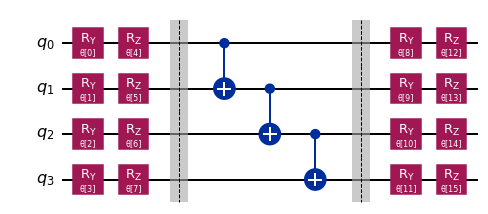

In [5]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear", insert_barriers=True)
ansatz.decompose().draw("mpl", style="iqx")

In [6]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=100)

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [7]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    quantum_instance=QasmSimulatorPy(),
)

local_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, local_vqe)

local_vqe_result = local_vqe_groundstate_solver.solve(problem)

In [8]:
print(
    "Energy:",
    np.real(local_vqe_result.eigenenergies + local_vqe_result.nuclear_repulsion_energy)[0],
)

Energy: -7.433591655718055


In [9]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
vqe_solver = VQEUCCFactory(quantum_instance=quantum_instance)

In [10]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')  # replace by your runtime provider

backend = provider.get_backend("ibmq_lima")  # select a backend that supports the runtime

In [11]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=100)

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [12]:
from qiskit_nature.runtime import VQEClient
runtime_vqe = VQEClient(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    provider=provider,
    backend=backend,
    shots=1024,
    measurement_error_mitigation=True,
)  # use a complete measurement fitter for error mitigation

In [13]:
runtime_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, runtime_vqe)
runtime_vqe_result = runtime_vqe_groundstate_solver.solve(problem)

KeyError: 'ParticleNumber'